# Playing around with Vega-Lite in IHaskell and JupyterLab

This is a *minimal* example showing how we can take advantage of the native support
for Vega-Lite visualizations in Jupyter Lab with IHaskell. The code also works in
Jupyter notebooks, but it is not quite "as good", since there is no PNG version
(so you don't have a representation of the plot when viewing the notebook outside
of the browser), and the code relies on a number of external Javascript libraries.

For the moment the `ihaskell-hvega` display program still defaults to supporting
the "notebook" rather than "lab" environment, hence the need to explicitly use the
`vlShow` function rather than it happening automatically.

## Running this notebook

This notebook uses `hvega-0.4.0.0`, `ihaskell-hvega-0.2.0.3`,
`ihaskell-display`, and [Tweag's jupyterWith environment](https://github.com/tweag/jupyterWith).
If you have `nix` installed then you should be able to use
[`shell.nix`](https://github.com/DougBurke/hvega/blob/master/notebooks/shell.nix) to
create the necessary environment with:

    % nix-shell --command "jupyter lab"
    
## Let's start at the beginning

We are going to start this notebook by loading in the `hvega` module (which provides
a pretty-direct encoding of the Vega-Lite schema into Haskell, and is based on the
[Elm Vega library](http://package.elm-lang.org/packages/gicentre/elm-vega/2.2.1/VegaLite)
by Jo Wood. There are some potential conflicts with other Haskell routines, such
as `filter`, hence the qualified import. Note that `IHaskell` automtically loads the
display code from the `ihaskell-hvega` package (if installed), which is where `vlShow`
comes from (the import of this is left as a comment as a reminder to me).

In [1]:
{-# LANGUAGE OverloadedStrings #-}

import qualified Graphics.Vega.VegaLite as VL
import Graphics.Vega.VegaLite hiding (filter)

-- import IHaskell.Display.Hvega (vlShow)

There are plenty of [awesome Vega-Lite examples](https://vega.github.io/vega-lite/examples/) but
I came up with the following when developing `hvega` and have stuck with it. I may well have to
rethink this!

First we create a Vega-Lite vizualization (`vl1`) using the
[`Graphics.Vega.VegaLite` module](https://hackage.haskell.org/package/hvega-0.1.0.3/docs/Graphics-Vega-VegaLite.html):

In [2]:
vl1 = 
  let desc = "A very exciting bar chart"

      dat = dataFromRows [Parse [("start", FoDate "%Y-%m-%d")]]
            . dataRow [("start", Str "2011-03-25"), ("count", Number 23)]
            . dataRow [("start", Str "2011-04-02"), ("count", Number 45)]
            . dataRow [("start", Str "2011-04-12"), ("count", Number 3)]

      barOpts = [MOpacity 0.4, MColor "teal"]

      enc = encoding
            . position X [PName "start", PmType Temporal, PAxis [AxTitle "Inception date"]]
            . position Y [PName "count", PmType Quantitative]
            
  in toVegaLite [description desc, background "white", dat [], mark Bar barOpts, enc []]

This has type `VegaLite`, which I would like to have auto-displayed, but as shown in cell 4 below,
the code from `IHaskell.Display.Vega` - which results in the visualization being displayed in a
Jupyter notebook - fails here: 

In [3]:
:t vl1

vl1 :: VegaLite

In [4]:
vl1

From within a browser you get the error `Javascript Error: requirejs is not defined`, and external viewers
see no output.

As a (hopefully) short-term work-around, I have the `vlShow` helper,
which converts the `VegaLite` type into one that can be automatically-displayed by Jupyter Lab:

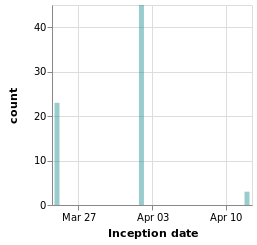

In [5]:
vlShow vl1

My, what a particularly-awesome visualization! When viewed within the Jupyter Lab browser, there
is a menu of items to the top-right of the visualization which lets you save the visualization as
`SVG` or `PNG`, or interact with the Vega-Lite representation directly.

Viewers reading the notebook "outside" of a browser - such as with
[GitHub's ipynb viewer](https://github.com/DougBurke/hvega/blob/master/notebooks/vegalite.ipynb) - will
see a PNG version of the visualization. For this (and the following) example there is
not-uch difference, but it makes more of a difference with the third plot,
which loses all the interactive interactivity in the PNG version ;-)

## A more-interesting example

We can show a bit-more power of Vega Lite: reading data from an external URL and doing a little-bit of
data-munging (this example is based on https://vega.github.io/vega-lite/examples/line.html).

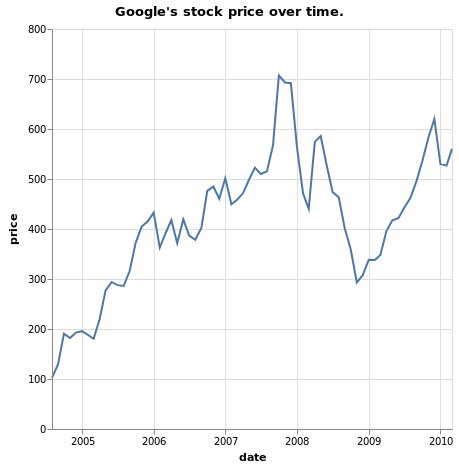

In [6]:
line =
    let dvals = dataFromUrl "https://vega.github.io/vega-datasets/data/stocks.csv"
        -- before version 0.4.0.0 title jjst took a string
        label = title "Google's stock price over time." []
           
        trans = transform
                   . VL.filter (FExpr "datum.symbol==='GOOG'")
                   
        enc = encoding
                 . position X [PName "date", PmType Temporal, PAxis [AxFormat "%Y"]]
                 . position Y [PName "price", PmType Quantitative]

    in toVegaLite [label, width 400, height 400, dvals [], trans [], mark Line [], enc []]
       
vlShow line

Now, the Vega-Lite data format is JSON, and the `VLSpec` type is just a simple wrapper around Aeson's `Value` type, so we can see the actual Vega-Lite specification with:

In [7]:
import Data.Aeson (encode)
import qualified Data.ByteString.Lazy.Char8 as BL

BL.putStrLn (encode (fromVL line))

{"transform":[{"filter":"datum.symbol==='GOOG'"}],"height":400,"mark":"line","data":{"url":"https://vega.github.io/vega-datasets/data/stocks.csv"},"width":400,"$schema":"https://vega.github.io/schema/vega-lite/v3.json","title":"Google's stock price over time.","encoding":{"x":{"field":"date","type":"temporal","axis":{"format":"%Y"}},"y":{"field":"price","type":"quantitative"}}}

If we write this out to a file, then you can display it directly with Jupyter Lab: it should appear in the file browser and double-clicking it will creata a new tab with the visualization (I think you can use either `.vl` or `.json.vl` as the file extension).

In [8]:
BL.writeFile "line.json.vl" (encode (fromVL line))

Perhaps I need to add some helper routines to simplify this!

Version `0.2.1.0` of `hvega` introduced the `toHtml` and `toHtmlFile` routines, which
create a HTML page which can be viewed in a web browser (and uses the JavaScript
[Vega Embed](https://vega.github.io/vega-lite/usage/embed.html) package).

In [9]:
toHtml line

"<!DOCTYPE html>\n<html>\n<head>\n  <script src=\"https://cdn.jsdelivr.net/npm/vega@5\"></script>\n  <script src=\"https://cdn.jsdelivr.net/npm/vega-lite@3\"></script>\n  <script src=\"https://cdn.jsdelivr.net/npm/vega-embed\"></script>\n</head>\n<body>\n<div id=\"vis\"></div>\n<script type=\"text/javascript\">\n  var spec = {\"transform\":[{\"filter\":\"datum.symbol==='GOOG'\"}],\"height\":400,\"mark\":\"line\",\"data\":{\"url\":\"https://vega.github.io/vega-datasets/data/stocks.csv\"},\"width\":400,\"$schema\":\"https://vega.github.io/schema/vega-lite/v3.json\",\"title\":\"Google's stock price over time.\",\"encoding\":{\"x\":{\"field\":\"date\",\"type\":\"temporal\",\"axis\":{\"format\":\"%Y\"}},\"y\":{\"field\":\"price\",\"type\":\"quantitative\"}}};\n  vegaEmbed('#vis', spec).then(function(result) {\n  // Access the Vega view instance (https://vega.github.io/vega/docs/api/view/) as result.view\n  }).catch(console.error);\n</script>\n</body>\n</html>\n"

## Interactivity rules

How about something a-bit-more interactive? This example is taken from
https://vega.github.io/vega-lite/examples/interactive_multi_line_tooltip.html

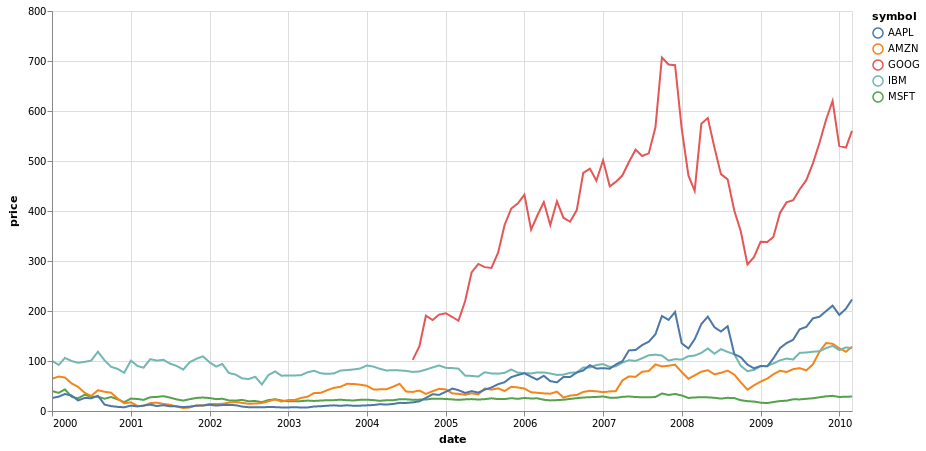

In [10]:
interactiveMultiLineTooltip =
    let dvals = dataFromUrl "https://vega.github.io/vega-datasets/data/stocks.csv"
                   [CSV, Parse [("date", FoDate "")]]
           
        enc = encoding
                 . position X [PName "date", PmType Temporal]
                 . position Y [PName "price", PmType Quantitative]
                 . color [MName "symbol", MmType Nominal]

        enc12 = encoding
                   . opacity [ MSelectionCondition (SelectionName "tooltip")
                               [MNumber 1] [MNumber 0]
                             ]
           
        lyr1 = asSpec [enc [], layer [lyr11, lyr12]]
        lyr11 = asSpec [mark Line []]
        lyr12 = asSpec [sel12 [], mark Point [], enc12 []]
        sel12 = selection
                   . select "tooltip" Single [Nearest True, On "mouseover", Empty, Encodings [ChX]]
           
        trans2 = transform
                    . VL.filter (FSelection "tooltip")
        
        posX = position X [PName "date", PmType Temporal]
        enc21 = encoding
                   . posX
        enc22 = encoding
                   . posX
                   . position Y [PName "price", PmType Quantitative]
                   . text [TName "price", TmType Quantitative]
                   . color [MName "symbol", MmType Nominal]
                   
        lyr21 = asSpec [mark Rule [MColor "gray"], enc21 []]
        lyr22 = asSpec [mark Text [MAlign AlignLeft, MdX 5, MdY (-5)], enc22 []]
           
        lyr2 = asSpec [trans2 [], layer [lyr21, lyr22]]
           
    in toVegaLite [dvals, width 800, height 400, layer [lyr1, lyr2]]
       
vlShow interactiveMultiLineTooltip

For those not viewing this directly in the notebook, a vertical bar is displayed as you move across the visualization, displaying the numerical values (the `price` values) of the curves at that point. 

And how does Jupyter Lab deal with this visualization when written out as a file?

In [11]:
BL.writeFile "interactive.json.vl" (encode (fromVL interactiveMultiLineTooltip))

Yay; interactive overload ahoy (if you double-click on `interactive.json.vl` in the file browser part of Jupyter Lab).